In [83]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.vgg19 import VGG19
tf.test.is_gpu_available()

True

In [84]:
# Hyperparameters
input_shape = 299
learning_rate = 1e-4
batch_size = 64
dropout_rate = 0.8
epoch = 3

In [85]:
train_path = '../input/chest-xray-pneumonia/chest_xray/train'
val_path = '../input/chest-xray-pneumonia/chest_xray/val'
test_path = '../input/chest-xray-pneumonia/chest_xray/test'

In [86]:
folders = glob(train_path + '/*')
categories = len(folders)

In [87]:
normal_train = glob(train_path + '/NORMAL/*')
pneumonia_train = glob(train_path + '/PNEUMONIA/*')
print(f'Number of images with no pneumonia is = {len(normal_train)}')
print(f'Number of images with pneumonia is = {len(pneumonia_train)}')

Number of images with no pneumonia is = 1341
Number of images with pneumonia is = 3875


In [88]:
normal_val = glob(val_path + '/NORMAL/*')
pneumonia_val = glob(val_path + '/PNEUMONIA/*')
print(f'Number of images with no pneumonia is = {len(normal_val)}')
print(f'Number of images with pneumonia is = {len(pneumonia_val)}')

Number of images with no pneumonia is = 8
Number of images with pneumonia is = 8


In [89]:
normal_test = glob(test_path + '/NORMAL/*')
pneumonia_test = glob(test_path + '/PNEUMONIA/*')
print(f'Number of images with no pneumonia is = {len(normal_test)}')
print(f'Number of images with pneumonia is = {len(pneumonia_test)}')

Number of images with no pneumonia is = 234
Number of images with pneumonia is = 390


In [90]:
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                            zoom_range = 0.2,
                                                            horizontal_flip = True,
                                                            rotation_range=0.3)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_ds = train_gen.flow_from_directory(train_path,
                                         target_size = (input_shape,input_shape),
                                         class_mode = 'binary',
                                         shuffle = True,
                                         batch_size = batch_size)
val_ds = test_gen.flow_from_directory(test_path,
                                      target_size = (input_shape,input_shape),
                                      class_mode = 'binary',
                                      shuffle = True,
                                      batch_size = batch_size)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [91]:
train_ds.class_indices

{'NORMAL': 0, 'PNEUMONIA': 1}

In [92]:
total_training_examples = len(normal_train + pneumonia_train)
print(f'Total Training Examples are = {total_training_examples}')

Total Training Examples are = 5216


In [93]:
neg = len(normal_train)
pos = len(pneumonia_train)
print(f'Total number corresponding to normal in training set = {neg}')
print(f'Total number corresponding to positive cases in training set = {pos}')

Total number corresponding to normal in training set = 1341
Total number corresponding to positive cases in training set = 3875


In [94]:
weight_for_norm = (1/neg) * (total_training_examples/2.0)
weight_for_pneu = (1/pos) * (total_training_examples/2.0)
class_weights = {0:weight_for_norm,1:weight_for_pneu}
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

### **Normal Model(Model without modification in loss function to overcome the imbalance)**

In [95]:
inception = InceptionV3(include_top = False,weights = 'imagenet',input_shape = [input_shape,input_shape] + [3])
for layer in inception.layers:
    layer.trainable = False

In [96]:
x = tf.keras.layers.Flatten()(inception.output)
x = tf.keras.layers.Dropout(dropout_rate)(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Dropout(dropout_rate)(x)
output = tf.keras.layers.Dense(units = 1,activation = 'sigmoid')(x)
model = tf.keras.Model(inputs = inception.input,outputs = output)
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_376 (Conv2D)             (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_376 (BatchN (None, 149, 149, 32) 96          conv2d_376[0][0]                 
__________________________________________________________________________________________________
activation_376 (Activation)     (None, 149, 149, 32) 0           batch_normalization_376[0][0]    
____________________________________________________________________________________________

In [97]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 0.005,patience = 2,verbose = 1)
optimiser = tf.keras.optimizers.Adam(learning_rate = learning_rate)
model.compile(loss = 'binary_crossentropy',
              optimizer = optimiser,
              metrics = ['accuracy'])
history = model.fit(train_ds,
          validation_data = val_ds,
          epochs = epoch,
          batch_size = batch_size,
          steps_per_epoch = len(train_ds),
          validation_steps = len(val_ds),
          validation_batch_size = batch_size,
          callbacks = [callback])

Epoch 1/3
82/82 [==============================] - 166s 2s/step - loss: 1.3159 - accuracy: 0.8149 - val_loss: 0.8080 - val_accuracy: 0.8798
Epoch 2/3
82/82 [==============================] - 163s 2s/step - loss: 0.7020 - accuracy: 0.9056 - val_loss: 0.8374 - val_accuracy: 0.8894
Epoch 3/3
82/82 [==============================] - 160s 2s/step - loss: 0.6616 - accuracy: 0.9163 - val_loss: 1.2083 - val_accuracy: 0.8558
Epoch 00003: early stopping


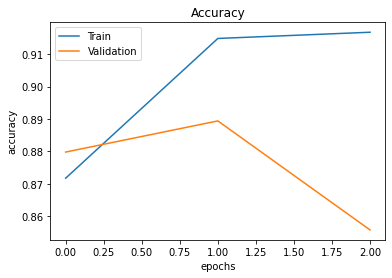

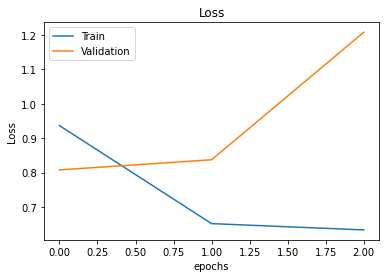

In [98]:
hist = history.history
plt.plot(hist['accuracy'])
plt.plot(hist['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend(['Train','Validation'])
plt.show()

plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(['Train','Validation'])
plt.show()

### **Modified loss function**

In [99]:
inception1 = InceptionV3(include_top = False,weights = 'imagenet',input_shape = [input_shape,input_shape] + [3])
for layer in inception1.layers:
    layer.trainable = False

In [100]:
y = tf.keras.layers.Flatten()(inception1.output)
y = tf.keras.layers.Dropout(dropout_rate)(y)
y = tf.keras.layers.Dense(64)(y)
y = tf.keras.layers.Dropout(dropout_rate)(y)
output_new = tf.keras.layers.Dense(units = 1,activation = 'sigmoid')(y)
new_model = tf.keras.Model(inputs = inception1.input,outputs = output_new)
new_model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_470 (Conv2D)             (None, 149, 149, 32) 864         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_470 (BatchN (None, 149, 149, 32) 96          conv2d_470[0][0]                 
__________________________________________________________________________________________________
activation_470 (Activation)     (None, 149, 149, 32) 0           batch_normalization_470[0][0]    
____________________________________________________________________________________________

In [102]:
callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',min_delta = 0.005,patience = 2,verbose = 1)
optimiser = tf.keras.optimizers.Adam(learning_rate = learning_rate)
new_model.compile(loss = 'binary_crossentropy',
              optimizer = optimiser,
              metrics = ['accuracy'])
new_history = new_model.fit(train_ds,
          validation_data = val_ds,
          epochs = 15,
          batch_size = batch_size,
          steps_per_epoch = len(train_ds),
          validation_steps = len(val_ds),
          validation_batch_size = batch_size,
          callbacks = [callback],
          class_weight = class_weights)

Epoch 1/15
82/82 [==============================] - 163s 2s/step - loss: 1.9064 - accuracy: 0.7821 - val_loss: 1.0497 - val_accuracy: 0.8590
Epoch 2/15
82/82 [==============================] - 154s 2s/step - loss: 1.0572 - accuracy: 0.8948 - val_loss: 0.9819 - val_accuracy: 0.8734
Epoch 3/15
82/82 [==============================] - 156s 2s/step - loss: 0.9036 - accuracy: 0.9165 - val_loss: 0.9314 - val_accuracy: 0.8974
Epoch 4/15
82/82 [==============================] - 154s 2s/step - loss: 0.7320 - accuracy: 0.9164 - val_loss: 0.9907 - val_accuracy: 0.8990
Epoch 5/15
82/82 [==============================] - 154s 2s/step - loss: 0.6787 - accuracy: 0.9212 - val_loss: 1.0648 - val_accuracy: 0.9071
Epoch 00005: early stopping


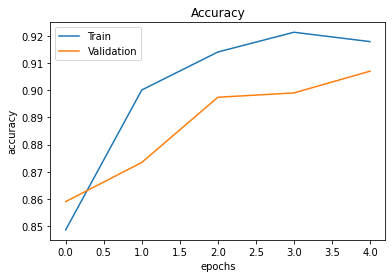

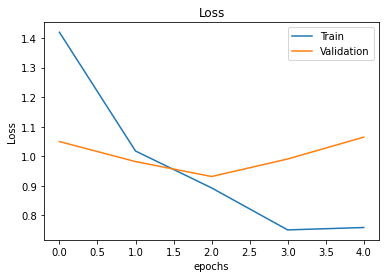

In [104]:
new_hist = new_history.history
plt.plot(new_hist['accuracy'])
plt.plot(new_hist['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.title('Accuracy')
plt.legend(['Train','Validation'])
plt.show()

plt.plot(new_hist['loss'])
plt.plot(new_hist['val_loss'])
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(['Train','Validation'])
plt.show()

In [105]:
model.save('model_inception.h5')

In [106]:
new_model.save('modified_loss_function.h5')